In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from utils.data import get_hsm_dataset
from utils.visualization import visualization

In [2]:
hsm_dataset_dir = Path("data/huge_stock_market_dataset/")
results_dir = Path("results")

In [3]:
hsm_info = pd.read_csv(hsm_dataset_dir / "selected100.csv")
hsm_info["ts_id"] = hsm_info.index

c:\Users\Владислав\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


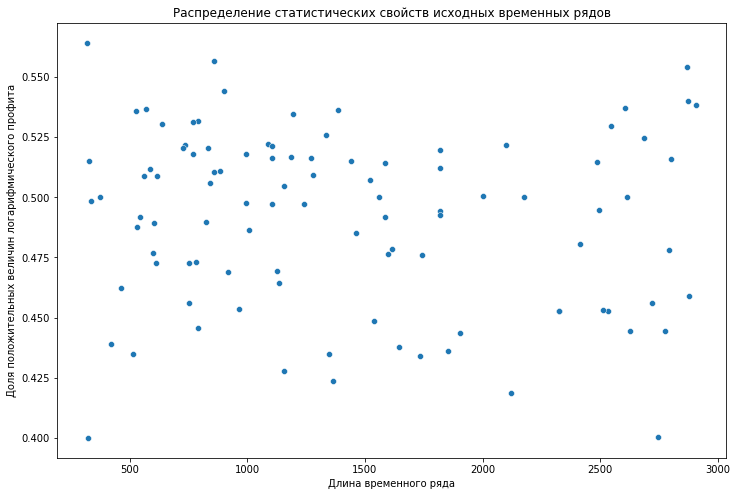

In [4]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(hsm_info["length"], y=hsm_info["uptrending_rate"], ax=ax)
ax.set_xlabel("Длина временного ряда")
ax.set_ylabel("Доля положительных величин логарифмического профита")
ax.set_title("Распределение статистических свойств исходных временных рядов")
plt.show()

In [47]:
results = []
for results_type in ("real", "QuantGAN", "FourierFlow", "RealNVP", "TTS_GAN"):
    for model in ("LSTM", "TCN", "cbr"):
        for dataset_name in ("hsm", "se"):
            if results_type == "real":
                df = pd.read_csv(results_dir / f"{results_type}_{dataset_name}_{model}.csv")
            else:
                df = pd.read_csv(results_dir / f"synth_{results_type}_{dataset_name}_{model}.csv")
            df["model"] = model
            df["results_type"] = results_type
            df["dataset"] = dataset_name
            results.append(df)
results = pd.concat(results)
# results["model"].replace("cbr", "CatBoostRegressor", inplace=True)
# results["results_type"].replace(["pure", "QuantGAN_synth", "FourierFlow_synth", "RealNVP_synth", "TTS_GAN_synth"],
#                                 ["train set", "QuantGAN synthetic data", "FourierFlow synthetic data", "RealNVP synthetic data", "TTS GAN synthetic data"], 
#                                 inplace=True)
results

,test,model,results_type,dataset
0,0.415065,LSTM,real,hsm
1,0.567788,LSTM,real,hsm
2,0.680561,LSTM,real,hsm
3,0.825972,LSTM,real,hsm
4,0.410212,LSTM,real,hsm
...,...,...,...,...
5,0.800413,cbr,TTS_GAN,se
6,0.871180,cbr,TTS_GAN,se
7,0.865102,cbr,TTS_GAN,se
8,0.854617,cbr,TTS_GAN,se


In [48]:
results_agg = results.groupby(by=["model", "results_type", "dataset"], axis=0, as_index=False).agg(test=("test", "mean"))
results_agg

,model,results_type,dataset,test
0,LSTM,FourierFlow,hsm,0.606643
1,LSTM,FourierFlow,se,0.390937
2,LSTM,QuantGAN,hsm,0.712685
3,LSTM,QuantGAN,se,0.410153
4,LSTM,RealNVP,hsm,0.498313
5,LSTM,RealNVP,se,0.078598
6,LSTM,TTS_GAN,hsm,0.819412
7,LSTM,TTS_GAN,se,0.885787
8,LSTM,real,hsm,0.532860
9,LSTM,real,se,0.120243


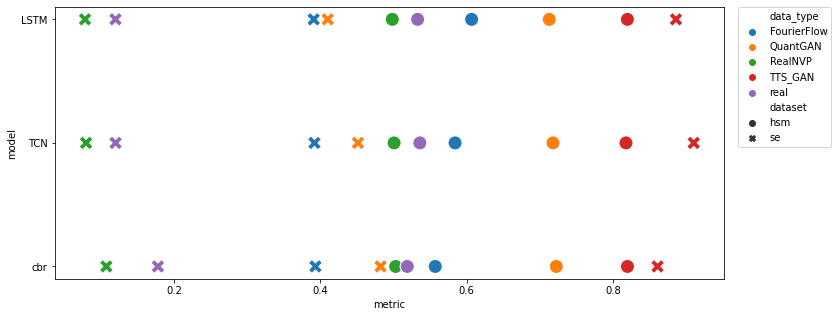

In [63]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.scatterplot(x=results_agg["test"].rename("metric"), y=results_agg["model"], 
    hue=results_agg["results_type"].rename("data_type"), style=results_agg["dataset"], s=200, ax=ax)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

# Synthetic similarity results

In [19]:
results = []
for model in ("QuantGAN", "RealNVP", "FourierFlow", "TTS_GAN"):
    for dataset_name in ("hsm", "se"):
        df = pd.read_csv(results_dir / f"synth_{dataset_name}_sim_{model}.csv").rename(columns={"sj_div": "js_div"})
        results.append({"model": model, "dataset": dataset_name,
        "kl_div": df["kl_div"].mean(), "js_div": df["js_div"].mean()})
synth_sim_results = pd.DataFrame(results)
synth_sim_results

,model,dataset,kl_div,js_div
0,QuantGAN,hsm,0.067871,0.018197
1,QuantGAN,se,0.093906,0.025480
2,RealNVP,hsm,0.007549,0.001956
3,RealNVP,se,0.020123,0.005023
4,FourierFlow,hsm,0.004134,0.001057
5,FourierFlow,se,0.000460,0.000114
6,TTS_GAN,hsm,0.062703,0.016734
7,TTS_GAN,se,0.107395,0.028375


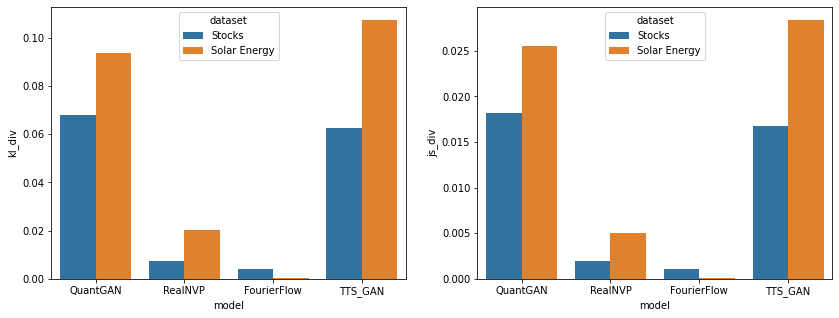

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
for i, metric_name in enumerate(("kl_div", "js_div")):
    sns.barplot(x=synth_sim_results["model"], y=synth_sim_results[metric_name], 
        hue=synth_sim_results["dataset"].replace({"hsm": "Stocks", "se": "Solar Energy"}), ax=axs[i])

In [32]:
dfs = {}
for res_type in ("real", "QuantGAN", "RealNVP", "FourierFlow", "TTS_GAN"):
    for model in ("cbr", "LSTM", "TCN"):
        for dataset_name in ("hsm", "se"):
            if res_type == "real":
                dfs[f"{res_type}_{model}_{dataset_name}"] = pd.read_csv(results_dir / f"{res_type}_{dataset_name}_{model}.csv")["test"]
            else:
                dfs[f"{res_type}_{model}_{dataset_name}"] = pd.read_csv(results_dir / f"synth_{res_type}_{dataset_name}_{model}.csv")["test"]
results = pd.DataFrame(dfs)
results

,real_cbr_hsm,real_cbr_se,real_LSTM_hsm,real_LSTM_se,real_TCN_hsm,real_TCN_se,QuantGAN_cbr_hsm,QuantGAN_cbr_se,QuantGAN_LSTM_hsm,QuantGAN_LSTM_se,...,FourierFlow_LSTM_hsm,FourierFlow_LSTM_se,FourierFlow_TCN_hsm,FourierFlow_TCN_se,TTS_GAN_cbr_hsm,TTS_GAN_cbr_se,TTS_GAN_LSTM_hsm,TTS_GAN_LSTM_se,TTS_GAN_TCN_hsm,TTS_GAN_TCN_se
0,0.401654,0.193247,0.415065,0.136675,0.403304,0.136627,0.647933,0.318791,0.595673,0.253133,...,0.459336,0.383409,0.481302,0.383449,0.781224,0.866811,0.781667,0.869790,0.783670,0.915316
1,0.536920,0.195709,0.567788,0.139915,0.569937,0.140487,0.698155,1.180843,0.700988,1.117416,...,0.721612,0.353464,0.593914,0.354911,0.798983,0.846603,0.797264,0.836445,0.798814,0.886362
2,0.651914,0.170422,0.680561,0.111841,0.694972,0.111904,0.762816,0.285646,0.755984,0.227144,...,0.711339,0.434038,0.707525,0.433194,0.871421,0.888075,0.865710,0.913982,0.864760,0.945612
3,0.774665,0.169113,0.825972,0.110642,0.802282,0.110606,0.744127,0.468419,0.738591,0.389470,...,0.806529,0.357166,0.799096,0.358788,0.728190,0.998256,0.712105,0.995523,0.716725,1.006423
4,0.423790,0.171898,0.410212,0.111111,0.404704,0.111037,0.651484,0.373093,0.576576,0.285137,...,0.510630,0.452557,0.503496,0.452538,0.859233,0.822255,0.869672,0.922551,0.864794,0.921938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.634223,NaN,0.680089,NaN,0.648382,NaN,0.722103,NaN,0.708613,NaN,...,0.701174,NaN,0.702847,NaN,0.831007,NaN,0.832135,NaN,0.825599,NaN
96,0.944157,NaN,1.059702,NaN,1.040683,NaN,0.697221,NaN,0.703835,NaN,...,0.994265,NaN,0.984637,NaN,0.835789,NaN,0.825679,NaN,0.826824,NaN
97,0.440769,NaN,0.429882,NaN,0.435115,NaN,0.667273,NaN,0.638825,NaN,...,0.587059,NaN,0.552551,NaN,0.810615,NaN,0.808820,NaN,0.809464,NaN
98,0.466428,NaN,0.449148,NaN,0.453674,NaN,0.602165,NaN,0.575982,NaN,...,0.545308,NaN,0.532113,NaN,0.794548,NaN,0.794908,NaN,0.793913,NaN


In [34]:
corrs = []
for model in ("cbr", "LSTM", "TCN"):
    for res_type in ("QuantGAN", "RealNVP", "FourierFlow", "TTS_GAN"):
        for dataset_name in ("hsm", "se"):
            if dataset_name == "hsm":
                res = np.corrcoef([results[f"real_{model}_{dataset_name}"],
                    results[f"{res_type}_{model}_{dataset_name}"]])[0][1]
            else:
                res = np.corrcoef([results[f"real_{model}_{dataset_name}"][:10],
                    results[f"{res_type}_{model}_{dataset_name}"][:10]])[0][1]
            corrs.append({"model": model, "synth_model": res_type, "dataset": dataset_name, "correlation": res})
corrs = pd.DataFrame(corrs)
corrs

,model,synth_model,dataset,correlation
0,cbr,QuantGAN,hsm,0.309590
1,cbr,QuantGAN,se,0.479963
2,cbr,RealNVP,hsm,0.983279
3,cbr,RealNVP,se,0.157367
4,cbr,FourierFlow,hsm,0.925422
5,cbr,FourierFlow,se,-0.290193
6,cbr,TTS_GAN,hsm,0.009140
7,cbr,TTS_GAN,se,-0.343893
8,LSTM,QuantGAN,hsm,0.281451
9,LSTM,QuantGAN,se,0.481261


In [36]:
corrs_agg = corrs.groupby(["dataset", "synth_model"], as_index=False).mean()
corrs_agg

C:\Users\Владислав\AppData\Local\Temp/ipykernel_10268/2987291452.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  corrs_agg = corrs.groupby(["dataset", "synth_model"], as_index=False).mean()


,dataset,synth_model,correlation
0,hsm,FourierFlow,0.924234
1,hsm,QuantGAN,0.282526
2,hsm,RealNVP,0.980081
3,hsm,TTS_GAN,-0.007814
4,se,FourierFlow,-0.302883
5,se,QuantGAN,0.482176
6,se,RealNVP,0.203733
7,se,TTS_GAN,-0.364587


<AxesSubplot:xlabel='synth_model', ylabel='correlation'>

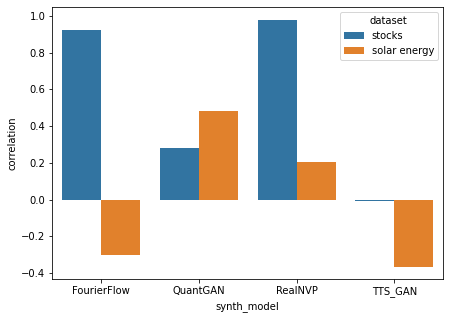

In [41]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(x=corrs_agg["synth_model"], y=corrs_agg["correlation"], 
    hue=corrs_agg["dataset"].replace({"se": "solar energy", "hsm": "stocks"}), ax=ax)